# Americium Cut based on Phi Position
The purpose of this notebook is to outline the Americium cut, following Matt's work [here (login required)](https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76/am_source_cut).

## Data Quality Cut
We begin by following the referenced [data quality cut page](https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76/data_quality_cuts#example).

In [48]:
#Imports
import sys
import numpy as np              #Will be used for binning
import pandas as pd             #Will be used for data structuring
import lmfit as lf
import matplotlib.pyplot as plt #Basic plotting library
sys.path.append('../')
from R76Tools import *          #Tools written by me for, e.x., importing our files
from matplotlib import cm

In [2]:
#User-set Variables
datapath = paths["fritts"]
ser = ["07220827_1153","07220916_2059","07220917_1039","07220917_2125"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"]

#Derived variables
nser = len(ser)
_,z = makechain_list(ser,path=datapath,filters=qualityfilters,aliases=qualityaliases)
for x in z:
    x["pt_keV_bscorr"] = x["pt_keV"]/(1-0.0461538*x["BSel"]/165)
    x["pt0_keV_bscorr"] = x["pt0_keV"]/(1-0.0461538*x["BSel"]/165)
    x["pt_keVee"] = 14.0821*x["pt_keV_bscorr"]/(333.899 - x["pt_keV_bscorr"])
    x["pt0_keVee"] = 14.0821*x["pt0_keV_bscorr"]/(333.899 - x["pt0_keV_bscorr"])

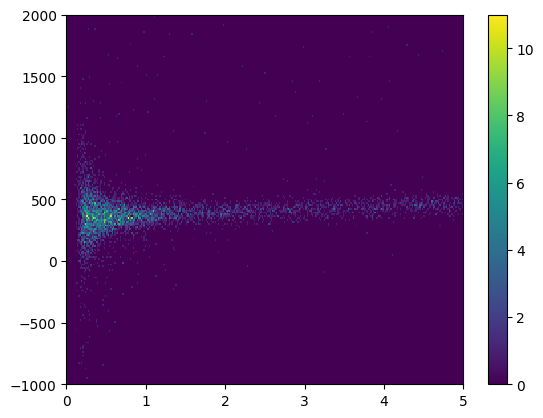

In [3]:
fig = plt.figure()
zcut = z[1][~z[1]["crand"] & z[1]["cbs"]]
h = plt.hist2d(zcut["pt_keVee"],zcut["PTINTall_PTbscorr"]/zcut["PTOFamps"],
           bins=[np.linspace(0,5,300),np.linspace(-1000,2000,200)])
fig.colorbar(h[3])
plt.show()

In [4]:
z_all = pd.DataFrame(); #z4_all = pd.DataFrame()
for i,x in enumerate(z):
    z_all = pd.concat([z_all,x])

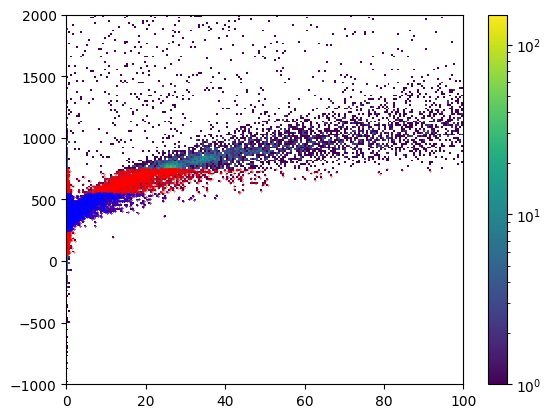

In [5]:
fig = plt.figure()

cmap = cm.viridis.copy()
cmap.set_under('w')
x = z[1]
zcut = x[~x["crand"] & (x["BSel"] < 1100)]

h = plt.hist2d(zcut["pt_keVee"],zcut["PTINTall_PTbscorr"]/zcut["PTOFamps"],
           bins=[np.linspace(0,100,200),np.linspace(-1000,2000,200)],
              norm = "log",vmax=150)
               #,cmap=cmap,vmin=1e-10)
plt.scatter(zcut["pt_keVee"][zcut["cofintl"]],zcut["PTINTall_PTbscorr"][zcut["cofintl"]]/zcut["PTOFamps"][zcut["cofintl"]]
           ,s=0.1,color='red')
plt.scatter(zcut["pt_keVee"][zcut["cofintt"]],zcut["PTINTall_PTbscorr"][zcut["cofintt"]]/zcut["PTOFamps"][zcut["cofintt"]]
           ,s=0.1,color='blue')
fig.colorbar(h[3])
plt.show()

There isn't code provided for this one, and the general idea is to show the cuts -- so I'm leaving it as-is for now.

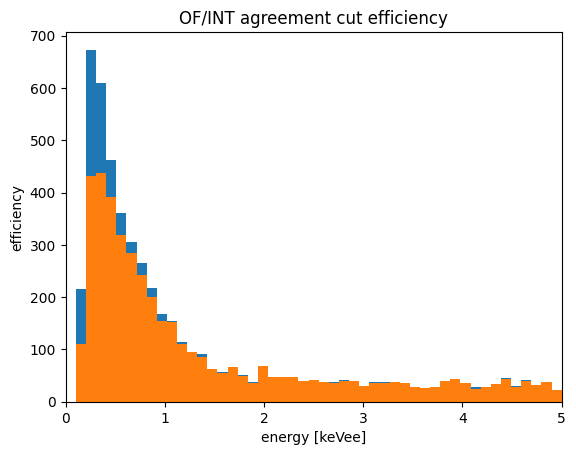

In [6]:
zcut = z[1][~z[1]["crand"] & z[1]["cbs"]]
hgood = plt.hist(zcut["pt_keVee"][zcut["cofintl"]],bins=np.linspace(0,5,50))#,align="left")
heff = plt.hist(zcut["pt_keVee"][zcut["cofintt"]],bins=np.linspace(0,5,50))#,align="left")
plt.title("OF/INT agreement cut efficiency")
plt.xlabel("energy [keVee]")
plt.ylabel("efficiency")
plt.xlim(0,5)
plt.show()

/tmp/ipykernel_2590925/719357565.py:1: RuntimeWarning: invalid value encountered in divide
  plt.step(heff[1][:-1],heff[0]/hgood[0])


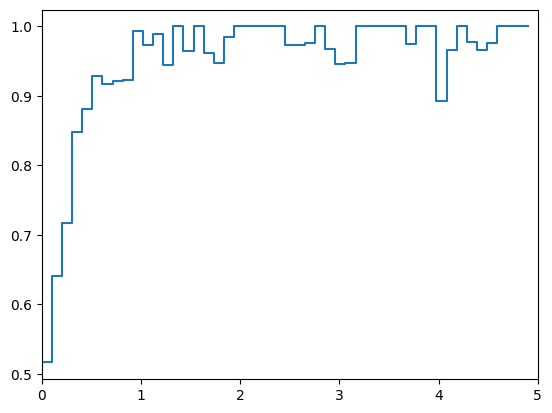

In [7]:
plt.step(heff[1][:-1],heff[0]/hgood[0])
plt.xlim(0,5)
plt.show()

Asked Matt about these, but he said to skip ahead to the improved cut, so we're doing that

### Improved Curved Cut

In [12]:
ser = ["07220916_2059","07220916_2200","07220917_1039","07220917_1225","07220917_2125","07220917_2155"]
ser = ser[::2] #Evens only
#lab = ["0V","-4V","-21V","-65V","-84V","-84V"]
nser = len(ser)

e,z,z4 = makechain_list(ser,path=datapath,filters=qualityfilters,aliases=qualityaliases,friends=True)
for x in z:
    x["pt_keV_bscorr"] = x["pt_keV"]/(1-0.0461538*x["BSel"]/165)
    x["pt0_keV_bscorr"] = x["pt0_keV"]/(1-0.0461538*x["BSel"]/165)
    x["pt_keVee"] = 14.0821*x["pt_keV_bscorr"]/(333.899 - x["pt_keV_bscorr"])
    x["pt0_keVee"] = 14.0821*x["pt0_keV_bscorr"]/(333.899 - x["pt0_keV_bscorr"])

['07220916_2059', '07220917_1039', '07220917_2125']


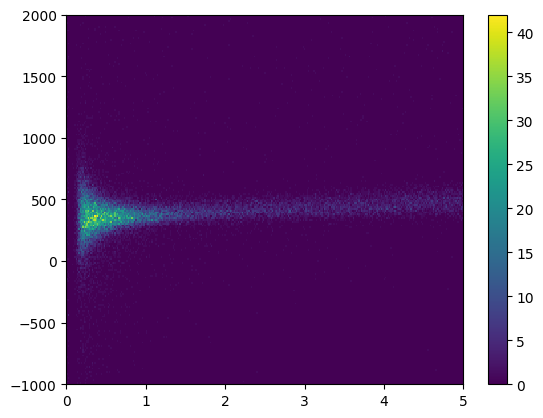

In [17]:
z_all = pd.DataFrame(); #z4_all = pd.DataFrame()
for i,x in enumerate(z):
    z_all = pd.concat([z_all,x])
x = z_all
zcut = x[~x["crand"] & x["cbs"]]
h = plt.hist2d(zcut["pt_keVee"],zcut["PTINTall_PTbscorr"]/zcut["PTOFamps"],
           bins=[np.linspace(0,5,300),np.linspace(-1000,2000,200)])
plt.colorbar(h[3])
plt.show()

In [54]:
edges = [0.1,0.2,0.3,0.4,0.6,0.8,1,1.5,2,3,4,5]
#print(h) #height,x,y
gaus_mod = lf.Model(gaus)
gaus_params = gaus_mod.make_params()
gaus_params.add('A',min=0,value=50)
gaus_params.add('sigma',min=0,value=3)
gaus_params.add('mu',value=400)

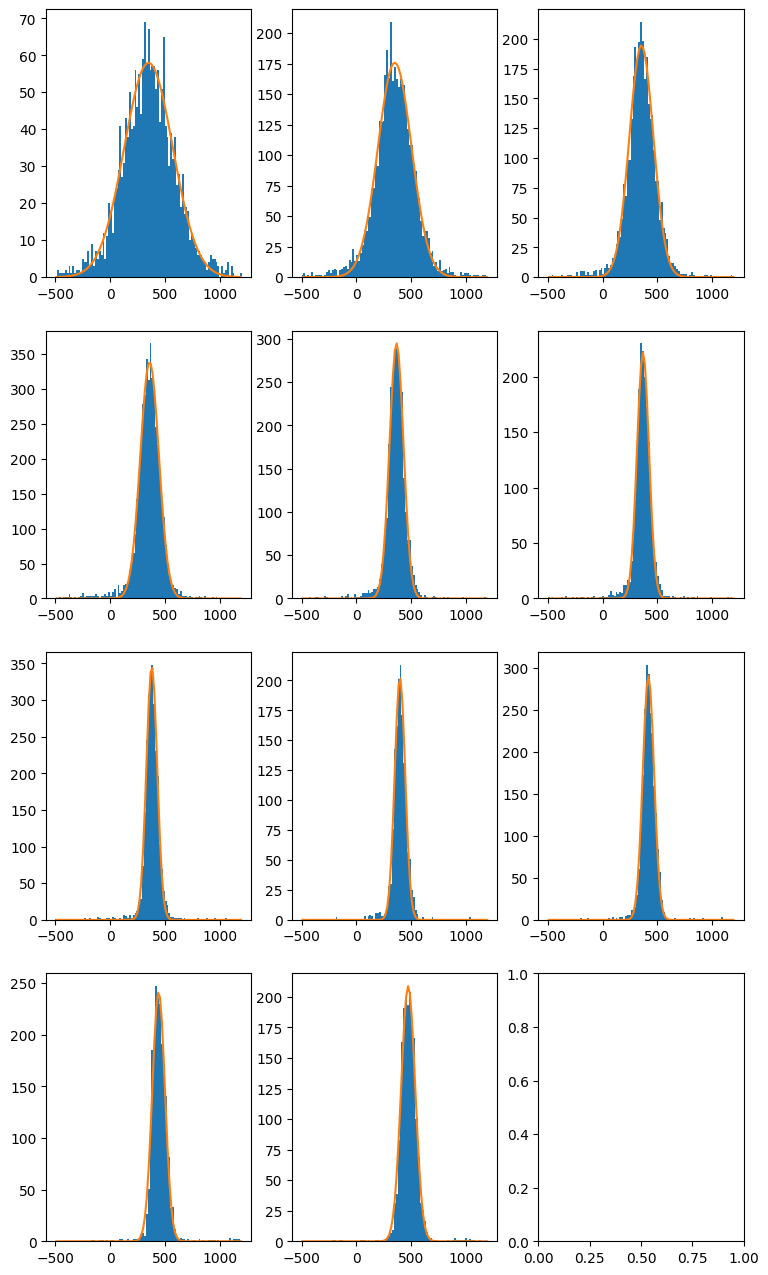

In [67]:
fig,axes = plt.subplots(4,3,figsize=(9,16))
x = z_all
fits = []
for i,row in enumerate(axes):
    for j,col in enumerate(row):
        try:
            zcut = x[~x["crand"] & x["cbs"] & (x["pt_keVee"]>edges[i*len(row)+j]) & (x["pt_keVee"]<edges[i*len(row)+j+1])]
            h = col.hist(zcut["PTINTall_PTbscorr"]/zcut["PTOFamps"],bins=np.linspace(-500,1200,100))
            bins = (h[1][:-1]+h[1][1:])/2
            fits.append(gaus_mod.fit(h[0],gaus_params,x=bins))
            col.plot(bins,fits[i*len(row)+j].best_fit)
        except IndexError:
            pass

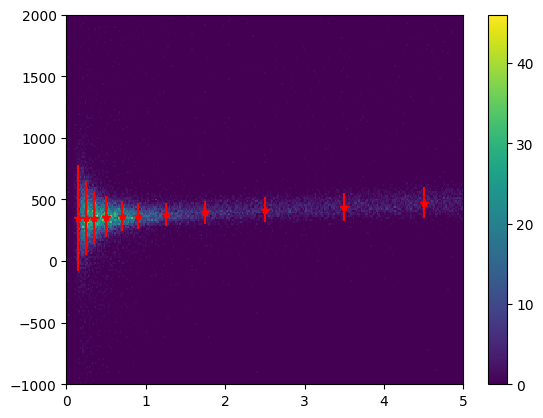

In [76]:
x = z_all
zcut = x[~x["crand"] & x["cbs"]]
h = plt.hist2d(zcut["pt_keVee"],zcut["PTINTall_PTbscorr"]/zcut["PTOFamps"],
           bins=[np.linspace(0,5,300),np.linspace(-1000,2000,200)],vmax=46)
plt.colorbar(h[3])
centers = (np.asarray(edges[:-1])+np.asarray(edges[1:]))/2
for i,fit in enumerate(fits):
    plt.errorbar(centers[i],fit.best_values['mu'],1.96*fit.best_values['sigma'],color="red",marker="*")
plt.show()

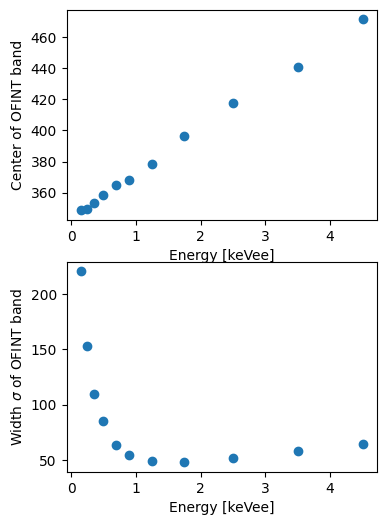

In [82]:
fig,ax = plt.subplots(2,1,figsize=(4,6))
ax[0].scatter(centers,[fit.best_values["mu"] for fit in fits])
ax[1].scatter(centers,[fit.best_values["sigma"] for fit in fits])
ax[0].set_xlabel("Energy [keVee]"); ax[1].set_xlabel("Energy [keVee]")
ax[0].set_ylabel("Center of OFINT band"); ax[1].set_ylabel(r"Width $\sigma$ of OFINT band")
plt.show()

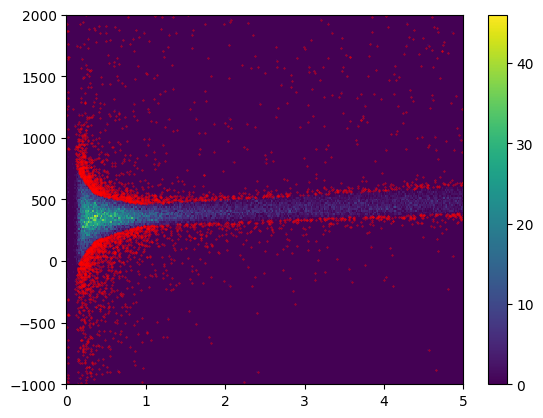

In [92]:
h = plt.hist2d(zcut["pt_keVee"],zcut["PTINTall_PTbscorr"]/zcut["PTOFamps"],
           bins=[np.linspace(0,5,300),np.linspace(-1000,2000,200)],vmax=46)
plt.colorbar(h[3])
z_all["ofint_sig"] = (z_all["pt_keVee"] <  0.3661)*(302.84*np.exp(-3.108*z_all["pt_keVee"])) + ((z_all["pt_keVee"] >= 0.3661) & (z_all["pt_keVee"] < 0.9452))*(42.044*z_all["pt_keVee"]**2 - 143.59*z_all["pt_keVee"] + 144) + (z_all["pt_keVee"]>=0.9452)*(0.5817*z_all["pt_keVee"]**2 - 0.833*z_all["pt_keVee"] + 46.109)
z_all["ofint_ctr"] = 343.7+34.18*z_all["pt_keVee"] - 0.5833*z_all["pt_keVee"]**2
z_all["cofintc"] = (z_all["PTINTall_PTbscorr"]/z_all["PTOFamps"] > z_all["ofint_ctr"] - 1.96*z_all["ofint_sig"]) & (z_all["PTINTall_PTbscorr"]/z_all["PTOFamps"] < z_all["ofint_ctr"] + 1.96*z_all["ofint_sig"])
zcut2 = z_all[~z_all["crand"] & z_all["cbs"] & ~z_all["cofintc"]]
plt.scatter(zcut2["pt_keVee"],zcut2["PTINTall_PTbscorr"]/zcut2["PTOFamps"],color='red',s=0.1)
plt.show()

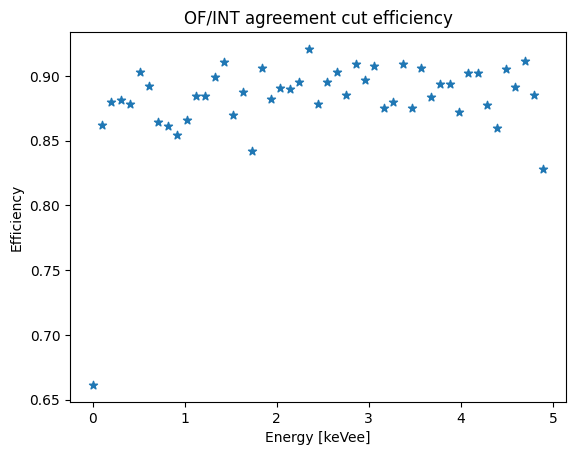

0.876981450252951


In [98]:
z_all["cofintvl"] = (z_all["PTINTall_PTbscorr"]/z_all["PTOFamps"] > -700) & (z_all["PTINTall_PTbscorr"]/z_all["PTOFamps"] < 1500)

zcut = z_all[~z_all["crand"] & z_all["cbs"] & z_all["cofintvl"]]
zcut2 = zcut[zcut["cofintc"]]

htotal = np.histogram(zcut["pt_keVee"],bins=np.linspace(0,5,50))
hpass = np.histogram(zcut2["pt_keVee"],bins=np.linspace(0,5,50))

plt.scatter(htotal[1][:-1],hpass[0]/htotal[0],marker="*")

plt.xlabel("Energy [keVee]"); plt.ylabel("Efficiency")
plt.title("OF/INT agreement cut efficiency")
plt.show()

npass = len(z_all[~z_all["crand"] & z_all["cbs"] & z_all["cofintc"] & (z_all["pt_keVee"] > 0.035) & (z_all["pt_keVee"] < 0.5)])
ngood = len(zcut[(zcut["pt_keVee"] > 0.035) & (zcut["pt_keVee"] < 0.5)])
print(npass/ngood)

Not sure how to get the error bars. The function called is defined [here](https://root.cern/doc/master/TH1_8cxx_source.html#l02950) but I don't see how it gets asymettric results? 